In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
sys.path.append('../../src') # path to src directory
import absolute_abundance_functions as aa

In [2]:
# qPCR-specific analysis portion
qpcr_path = "input/qpcr_data_example.xlsx" # user edit
qpcr_sheet_name = "Sheet1" # user edit

layout_path = "input/qpcr_layout_example.xlsx" # user edit
layout_sheet_name = "Sheet1" # user edit

format_conversion_path = "../../artifacts/format_conversion.tsv" # path to format conversion file

# Universal analysis portion
weights_path = "input/qpcr_weights_example.xlsx" # user edit
weights_sheet_name = "Sheet1" # user edit

nist_expected_path = "../../artifacts/nist_expected_values_03262024.xlsx" # path to NIST expected file
nist_expected_sheet_name = "Sheet1" # NIST expected sheet name

In [3]:
param_dict_qpcr = {
    "PCOPY": 8.34e10, # user edit
    "FCOPY": 1.25e11, # user edit
    "NUM_OF_TECH_REPS": 3,
    "MAX_CQ_SPAN_NTC": 2.0,
    "MAX_CQ_SPAN_STANDARD_DIL_PT": 2.0,
    "MAX_STANDARD_DIL_PTS_REMOVED_TECH_VAR": 1,
    "MIN_CQ_GAP_CONC_STANDARDS": 3.11,
    "CQ_CUTOFF_CONC_STANDARDS": 15.0,
    "CQ_STANDARDS_SEP_LOB": 2.0,
    "MAX_FOLD_CHANGE_PVUL_FPRA": 2.0,
    "MOST_STEEP_SLOPE_ALLOWED": -3.58,
    "LEAST_STEEP_SLOPE_ALLOWED": -3.11,
    "MIN_R_SQUARED": 0.98,
    "CQ_NON_STANDARDS_SEP_LOB": 2.0,
    "OVERHANG_ALLOWED": False,
    "MAX_COPIES_RXN_LOB": 500,
    "MAX_CQ_DIFF_SAMPLE_CLOSEST_TWO_REPS": 2.0,
    "CQ_LOW_CONF_SEP_LOB": 3.3,
}

param_dict_univ = {
    "NIST_MAX_FOLD_DIFF": 5.0,
    "NEG_EXTRACT_CTRL_MAX_COPIES": 5000.0,
    "POS_EXTRACT_CTRL_MAX_SPAN": 2,
    "EXTRACT_MAX_INPUT": 0.250,
    "EXTRACT_MIN_INPUT": 0.150,
    "DRYING_MAX_INPUT": 0.125,
    "DRYING_MIN_INPUT": 0.075,
    "MIN_DRIED_DRY_MASS": 0.008,
    "WATER_FRACTION_CUTOFF": 0.9,
}

In [4]:
aa.prepare_matplotlib()

# qPCR-specific analysis

## Load data

In [5]:
format_conversion = pd.read_csv(format_conversion_path, sep="\t", names=["Well96", "Replica", "Well384"])
layout96 = pd.read_excel(layout_path, sheet_name=layout_sheet_name)
qpcr = pd.read_excel(qpcr_path, sheet_name=qpcr_sheet_name)

In [6]:
format_conversion

,Well96,Replica,Well384
0,A1,Rep1,A1
1,A1,Rep2,A2
2,A1,Rep3,B1
3,A1,Rep4,B2
4,B1,Rep1,C1
...,...,...,...
379,G12,Rep4,N24
380,H12,Rep1,O23
381,H12,Rep2,O24
382,H12,Rep3,P23


In [7]:
layout96

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume
0,A1,NIST_A,1000.0,10.0,PCRPos,6.0,NaN
1,B1,NTC_1,1000.0,1.0,PCRNeg,6.0,NaN
2,C1,NIST_L,1000.0,10.0,PCRPos,6.0,NaN
3,D1,NTC_2,1000.0,1.0,PCRNeg,6.0,NaN
4,E1,NIST_O,1000.0,10.0,PCRPos,6.0,NaN
...,...,...,...,...,...,...,...
91,D12,NaN,NaN,NaN,NaN,NaN,NaN
92,E12,NaN,NaN,NaN,NaN,NaN,NaN
93,F12,NaN,NaN,NaN,NaN,NaN,NaN
94,G12,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
qpcr

,Well,Cq
0,A1,17.1
1,A2,17.2
2,A3,22.8
3,A4,22.7
4,A5,6.5
...,...,...
379,P20,NaN
380,P21,NaN
381,P22,NaN
382,P23,NaN


## Name unique

In [9]:
vc = layout96["Name"].value_counts()
if vc.max() > 1:
    vc = vc[vc > 1]
    raise ValueError(f"{len(vc)} sample names occur more than once: {", ".join(vc.index)}")

## Formatting

In [10]:
qpcr2, layout96 = aa.qpcr_initial_formatting(layout96, format_conversion, qpcr, param_dict_qpcr)

In [11]:
qpcr2

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq
0,A01,Rep1,A1,NIST_A,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.1
1,A01,Rep2,A2,NIST_A,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.2
2,A01,Rep3,B1,NIST_A,1000.0,10.0,PCRPos,6.0,NaN,10000.0,16.8
3,B01,Rep1,C1,NTC_1,1000.0,1.0,PCRNeg,6.0,NaN,1000.0,26.1
4,B01,Rep2,C2,NTC_1,1000.0,1.0,PCRNeg,6.0,NaN,1000.0,26
...,...,...,...,...,...,...,...,...,...,...,...
283,G12,Rep2,M24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,G12,Rep3,N23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,H12,Rep1,O23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,H12,Rep2,O24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tech rep failures

In [12]:
qpcr3, fewer_than_two_reps = aa.manage_tech_rep_failures(qpcr2)

In [13]:
qpcr3

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq
0,A01,Rep1,A1,NIST_A,1000.0,1.000000e+01,PCRPos,6.0,NaN,1.000000e+04,17.1
1,A01,Rep2,A2,NIST_A,1000.0,1.000000e+01,PCRPos,6.0,NaN,1.000000e+04,17.2
2,A01,Rep3,B1,NIST_A,1000.0,1.000000e+01,PCRPos,6.0,NaN,1.000000e+04,16.8
3,B01,Rep1,C1,NTC_1,1000.0,1.000000e+00,PCRNeg,6.0,NaN,1.000000e+03,26.1
4,B01,Rep2,C2,NTC_1,1000.0,1.000000e+00,PCRNeg,6.0,NaN,1.000000e+03,26.0
...,...,...,...,...,...,...,...,...,...,...,...
91,G04,Rep2,M8,Fpra_8,1.0,1.000000e+08,Fpra,6.0,NaN,1.000000e+08,23.7
92,G04,Rep3,N7,Fpra_8,1.0,1.000000e+08,Fpra,6.0,NaN,1.000000e+08,24.8
93,H04,Rep1,O7,Fpra_9,1.0,1.000000e+09,Fpra,6.0,NaN,1.000000e+09,25.9
94,H04,Rep2,O8,Fpra_9,1.0,1.000000e+09,Fpra,6.0,NaN,1.000000e+09,24.7


In [14]:
fewer_than_two_reps

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq


## No template controls and LOB

In [15]:
Cq_NTC_span, param_dict_qpcr = aa.assess_NTC(qpcr3, param_dict_qpcr)

In [16]:
param_dict_qpcr["CQ_LIMIT_OF_BLANK"]

25.9

In [17]:
Cq_NTC_span

0.6000000000000014

In [18]:
param_dict_qpcr["MAX_CQ_SPAN_NTC"]

2.0

## Standard curve

In [19]:
pvul1 = qpcr3[qpcr3["Type"].isin(["Pvul"])].copy()
fpra1 = qpcr3[qpcr3["Type"].isin(["Fpra"])].copy()
pvul2 = aa.calculate_qubit_copies(pvul1, param_dict_qpcr["PCOPY"])
fpra2 = aa.calculate_qubit_copies(fpra1, param_dict_qpcr["FCOPY"])

In [20]:
pvul2

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn
48,A03,Rep1,A5,Pvul_2,1.0,1.000000e+02,Pvul,6.0,NaN,1.000000e+02,6.5,834000000.0
49,A03,Rep2,A6,Pvul_2,1.0,1.000000e+02,Pvul,6.0,NaN,1.000000e+02,6.4,834000000.0
50,A03,Rep3,B5,Pvul_2,1.0,1.000000e+02,Pvul,6.0,NaN,1.000000e+02,6.8,834000000.0
51,B03,Rep1,C5,Pvul_3,1.0,1.000000e+03,Pvul,6.0,NaN,1.000000e+03,7.0,83400000.0
52,B03,Rep2,C6,Pvul_3,1.0,1.000000e+03,Pvul,6.0,NaN,1.000000e+03,6.9,83400000.0
53,B03,Rep3,D5,Pvul_3,1.0,1.000000e+03,Pvul,6.0,NaN,1.000000e+03,7.2,83400000.0
54,C03,Rep1,E5,Pvul_4,1.0,1.000000e+04,Pvul,6.0,NaN,1.000000e+04,10.7,8340000.0
55,C03,Rep2,E6,Pvul_4,1.0,1.000000e+04,Pvul,6.0,NaN,1.000000e+04,10.4,8340000.0
56,C03,Rep3,F5,Pvul_4,1.0,1.000000e+04,Pvul,6.0,NaN,1.000000e+04,10.2,8340000.0
57,D03,Rep1,G5,Pvul_5,1.0,1.000000e+05,Pvul,6.0,NaN,1.000000e+05,13.6,834000.0


In [21]:
fpra2

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn
72,A04,Rep1,A7,Fpra_2,1.0,1.000000e+02,Fpra,6.0,NaN,1.000000e+02,6.7,1.250000e+09
73,A04,Rep2,A8,Fpra_2,1.0,1.000000e+02,Fpra,6.0,NaN,1.000000e+02,7.0,1.250000e+09
74,A04,Rep3,B7,Fpra_2,1.0,1.000000e+02,Fpra,6.0,NaN,1.000000e+02,7.1,1.250000e+09
75,B04,Rep1,C7,Fpra_3,1.0,1.000000e+03,Fpra,6.0,NaN,1.000000e+03,7.7,1.250000e+08
76,B04,Rep2,C8,Fpra_3,1.0,1.000000e+03,Fpra,6.0,NaN,1.000000e+03,7.5,1.250000e+08
77,B04,Rep3,D7,Fpra_3,1.0,1.000000e+03,Fpra,6.0,NaN,1.000000e+03,7.1,1.250000e+08
78,C04,Rep1,E7,Fpra_4,1.0,1.000000e+04,Fpra,6.0,NaN,1.000000e+04,10.5,1.250000e+07
79,C04,Rep2,E8,Fpra_4,1.0,1.000000e+04,Fpra,6.0,NaN,1.000000e+04,10.6,1.250000e+07
80,C04,Rep3,F7,Fpra_4,1.0,1.000000e+04,Fpra,6.0,NaN,1.000000e+04,10.1,1.250000e+07
81,D04,Rep1,G7,Fpra_5,1.0,1.000000e+05,Fpra,6.0,NaN,1.000000e+05,13.7,1.250000e+06


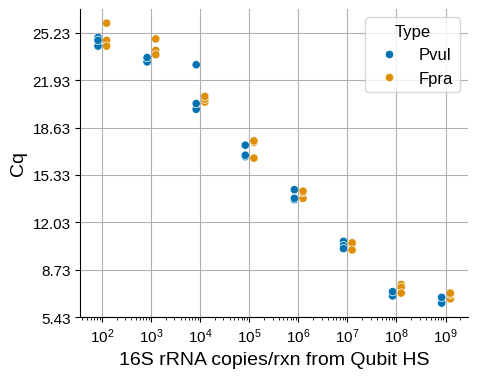

In [22]:
aa.visualize_standards(df_p=pvul2, df_f=fpra2)

In [23]:
pvul3, p_var_dilutions_removed = aa.remove_dilutions_with_tech_rep_variation(pvul2, param_dict_qpcr)
fpra3, f_var_dilutions_removed = aa.remove_dilutions_with_tech_rep_variation(fpra2, param_dict_qpcr)
p_var_dilutions_removed_number = p_var_dilutions_removed["Dilution"].nunique()
f_var_dilutions_removed_number = f_var_dilutions_removed["Dilution"].nunique()

In [24]:
p_var_dilutions_removed

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn,reason_for_removal
63,F03,Rep1,K5,Pvul_7,1.0,10000000.0,Pvul,6.0,NaN,10000000.0,19.9,8340.0,standard_plasmid_tech_rep_variation
64,F03,Rep2,K6,Pvul_7,1.0,10000000.0,Pvul,6.0,NaN,10000000.0,20.3,8340.0,standard_plasmid_tech_rep_variation
65,F03,Rep3,L5,Pvul_7,1.0,10000000.0,Pvul,6.0,NaN,10000000.0,23.0,8340.0,standard_plasmid_tech_rep_variation


In [25]:
f_var_dilutions_removed

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn,reason_for_removal


In [26]:
param_dict_qpcr["MAX_STANDARD_DIL_PTS_REMOVED_TECH_VAR"]

1

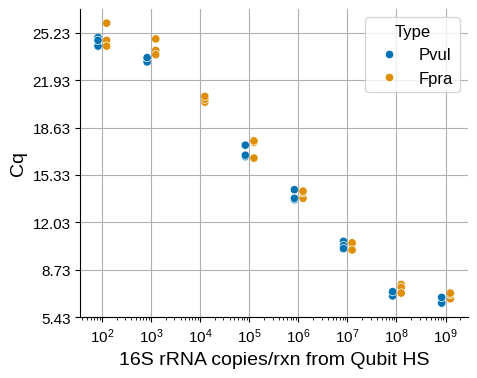

In [27]:
aa.visualize_standards(df_p=pvul3, df_f=fpra3)

In [28]:
pvul4, p_conc_dilutions_removed = aa.remove_concentrated_standards(pvul3, param_dict_qpcr)
fpra4, f_conc_dilutions_removed = aa.remove_concentrated_standards(fpra3, param_dict_qpcr)

In [29]:
p_conc_dilutions_removed

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn,reason_for_removal
48,A03,Rep1,A5,Pvul_2,1.0,100.0,Pvul,6.0,NaN,100.0,6.5,834000000.0,standard_plasmid_too_concentrated
49,A03,Rep2,A6,Pvul_2,1.0,100.0,Pvul,6.0,NaN,100.0,6.4,834000000.0,standard_plasmid_too_concentrated
50,A03,Rep3,B5,Pvul_2,1.0,100.0,Pvul,6.0,NaN,100.0,6.8,834000000.0,standard_plasmid_too_concentrated


In [30]:
f_conc_dilutions_removed

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn,reason_for_removal
72,A04,Rep1,A7,Fpra_2,1.0,100.0,Fpra,6.0,NaN,100.0,6.7,1.250000e+09,standard_plasmid_too_concentrated
73,A04,Rep2,A8,Fpra_2,1.0,100.0,Fpra,6.0,NaN,100.0,7.0,1.250000e+09,standard_plasmid_too_concentrated
74,A04,Rep3,B7,Fpra_2,1.0,100.0,Fpra,6.0,NaN,100.0,7.1,1.250000e+09,standard_plasmid_too_concentrated
75,B04,Rep1,C7,Fpra_3,1.0,1000.0,Fpra,6.0,NaN,1000.0,7.7,1.250000e+08,standard_plasmid_too_concentrated
76,B04,Rep2,C8,Fpra_3,1.0,1000.0,Fpra,6.0,NaN,1000.0,7.5,1.250000e+08,standard_plasmid_too_concentrated
77,B04,Rep3,D7,Fpra_3,1.0,1000.0,Fpra,6.0,NaN,1000.0,7.1,1.250000e+08,standard_plasmid_too_concentrated


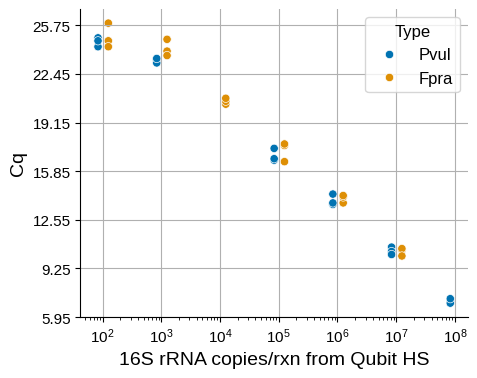

In [31]:
aa.visualize_standards(df_p=pvul4, df_f=fpra4)

In [32]:
pvul5, p_dil_dilutions_removed = aa.remove_dilute_standards(pvul4, param_dict_qpcr)
fpra5, f_dil_dilutions_removed = aa.remove_dilute_standards(fpra4, param_dict_qpcr)

In [33]:
p_dil_dilutions_removed

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn,reason_for_removal
69,H03,Rep1,O5,Pvul_9,1.0,1.000000e+09,Pvul,6.0,NaN,1.000000e+09,24.3,83.4,standard_plasmid_too_dilute
70,H03,Rep2,O6,Pvul_9,1.0,1.000000e+09,Pvul,6.0,NaN,1.000000e+09,24.9,83.4,standard_plasmid_too_dilute
71,H03,Rep3,P5,Pvul_9,1.0,1.000000e+09,Pvul,6.0,NaN,1.000000e+09,24.7,83.4,standard_plasmid_too_dilute


In [34]:
f_dil_dilutions_removed

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,Q_copies_rxn,reason_for_removal
90,G04,Rep1,M7,Fpra_8,1.0,1.000000e+08,Fpra,6.0,NaN,1.000000e+08,24.0,1250.0,standard_plasmid_too_dilute
91,G04,Rep2,M8,Fpra_8,1.0,1.000000e+08,Fpra,6.0,NaN,1.000000e+08,23.7,1250.0,standard_plasmid_too_dilute
92,G04,Rep3,N7,Fpra_8,1.0,1.000000e+08,Fpra,6.0,NaN,1.000000e+08,24.8,1250.0,standard_plasmid_too_dilute
93,H04,Rep1,O7,Fpra_9,1.0,1.000000e+09,Fpra,6.0,NaN,1.000000e+09,25.9,125.0,standard_plasmid_too_dilute
94,H04,Rep2,O8,Fpra_9,1.0,1.000000e+09,Fpra,6.0,NaN,1.000000e+09,24.7,125.0,standard_plasmid_too_dilute
95,H04,Rep3,P7,Fpra_9,1.0,1.000000e+09,Fpra,6.0,NaN,1.000000e+09,24.3,125.0,standard_plasmid_too_dilute


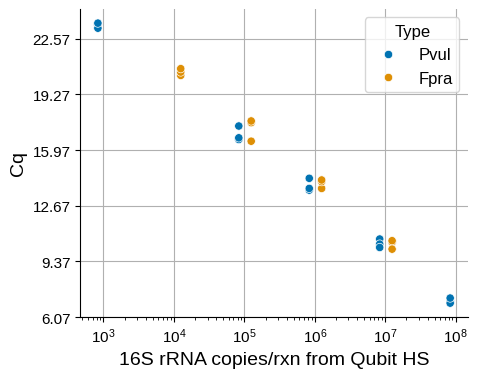

In [35]:
aa.visualize_standards(df_p=pvul5, df_f=fpra5)

In [36]:
maximum_pvul_fpra_discrepancy = aa.compare_pvul_fpra(pvul5, fpra5)
maximum_pvul_fpra_discrepancy

1.4305830322354098

In [37]:
param_dict_qpcr["MAX_FOLD_CHANGE_PVUL_FPRA"]

2.0

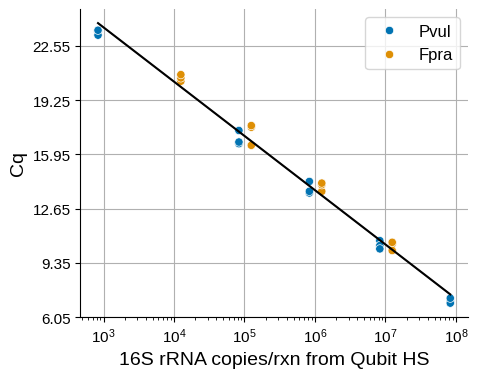

In [38]:
smodel, param_dict_qpcr = aa.final_linear_regression(pvul5, fpra5, param_dict_qpcr)
aa.plot_standard_model(pvul5, fpra5, smodel)

In [39]:
smodel

LinregressResult(slope=-3.3002190707474646, intercept=33.5729210946168, rvalue=-0.9944462361795507, pvalue=5.701494697716824e-26, stderr=0.06985481184318554, intercept_stderr=0.40915306400318924)

In [40]:
10**(-1/smodel.slope) - 1 # efficiency

1.0091399424436633

In [41]:
smodel.rvalue * smodel.rvalue

0.9889233166516749

In [42]:
param_dict_qpcr["CQ_LIMIT_OF_BLANK"]

25.9

In [43]:
param_dict_qpcr["CQ_OF_MOST_DILUTE_STANDARD_POINT"]

23.4

In [44]:
param_dict_qpcr["CQ_OF_MOST_CONC_STANDARD_POINT"]

7.0

In [45]:
param_dict_qpcr = aa.calculate_cq_limit_of_quantification(param_dict_qpcr)

In [46]:
param_dict_qpcr["CQ_LIMIT_OF_QUANTIFICATION"]

23.4

In [47]:
param_dict_qpcr = aa.qpcr_calculate_copies_per_reaction_lob(smodel, param_dict_qpcr)

In [48]:
param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"]

211.33589183482096

In [49]:
param_dict_qpcr["MAX_COPIES_RXN_LOB"]

500

## Samples and controls

In [50]:
samples_controls = qpcr3[qpcr3["Type"].isin(["PCRPos", "DNAPos", "DNANeg", "Sample"])]

### Example easy seaborn plot

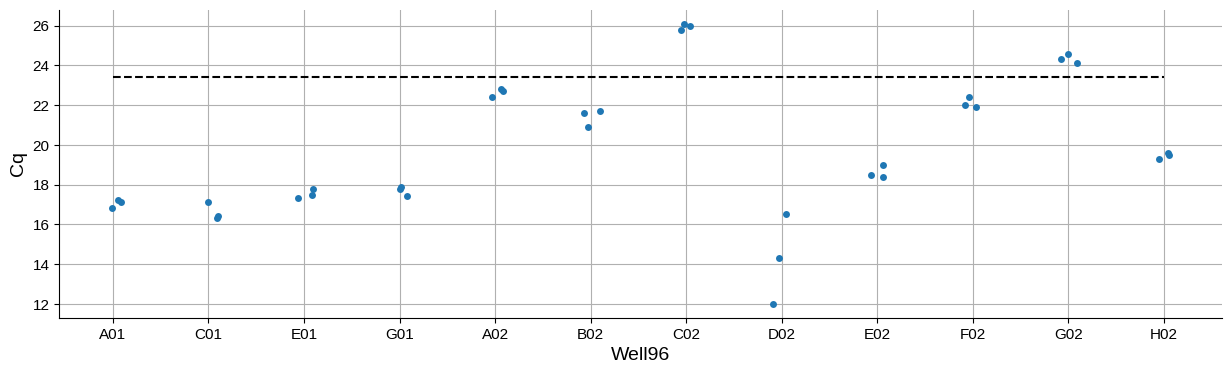

In [51]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
sns.stripplot(data=samples_controls, x="Well96", y="Cq")
ax1.plot([0, samples_controls.Well96.nunique()-1], [param_dict_qpcr["CQ_LIMIT_OF_QUANTIFICATION"], param_dict_qpcr["CQ_LIMIT_OF_QUANTIFICATION"]], color="black", linestyle="dashed")
plt.grid()
sns.despine()

In [52]:
samples_controls2, samples_controls_high_variation = aa.identify_samples_with_tech_rep_variation(samples_controls, param_dict_qpcr)

In [53]:
samples_controls2

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq
0,A01,Rep1,A1,NIST_A,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.1
1,A01,Rep2,A2,NIST_A,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.2
2,A01,Rep3,B1,NIST_A,1000.0,10.0,PCRPos,6.0,NaN,10000.0,16.8
6,C01,Rep1,E1,NIST_L,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.1
7,C01,Rep2,E2,NIST_L,1000.0,10.0,PCRPos,6.0,NaN,10000.0,16.4
8,C01,Rep3,F1,NIST_L,1000.0,10.0,PCRPos,6.0,NaN,10000.0,16.3
12,E01,Rep1,I1,NIST_O,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.5
13,E01,Rep2,I2,NIST_O,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.8
14,E01,Rep3,J1,NIST_O,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.3
18,G01,Rep1,M1,NIST_mix_A_R,1000.0,10.0,PCRPos,6.0,NaN,10000.0,17.9


In [54]:
samples_controls_high_variation

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,Cq,reason_for_removal
33,D02,Rep1,G3,my_extraction_4,1000.0,1.0,Sample,6.0,100.0,1000.0,16.5,tech_rep_variation
34,D02,Rep2,G4,my_extraction_4,1000.0,1.0,Sample,6.0,100.0,1000.0,14.3,tech_rep_variation
35,D02,Rep3,H3,my_extraction_4,1000.0,1.0,Sample,6.0,100.0,1000.0,12.0,tech_rep_variation


In [55]:
samples_controls3 = aa.calculate_medians(samples_controls2, layout96)

In [56]:
samples_controls3

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution
0,NIST_A,17.1,17.2,16.8,A01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
1,NIST_L,16.4,17.1,16.3,C01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
2,NIST_O,17.5,17.8,17.3,E01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
3,NIST_mix_A_R,17.8,17.9,17.4,G01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
4,my_extraction_1,22.7,22.8,22.4,A02,1000.0,1.0,Sample,6.0,100.0,1000.0
5,my_extraction_2,21.6,21.7,20.9,B02,1000.0,1.0,DNAPos,6.0,100.0,1000.0
6,my_extraction_3,26.0,26.1,25.8,C02,1000.0,1.0,Sample,6.0,100.0,1000.0
7,my_extraction_5,18.5,19.0,18.4,E02,10.0,1.0,Sample,6.0,100.0,10.0
8,my_extraction_6,22.0,22.4,21.9,F02,10.0,1.0,Sample,6.0,100.0,10.0
9,my_extraction_7,24.3,24.6,24.1,G02,1.0,1.0,DNANeg,6.0,100.0,1.0


In [57]:
samples_controls4, samples_controls_too_dilute, samples_controls_too_conc = aa.cq_falls_in_quantifiable_range(samples_controls3, param_dict_qpcr)

In [58]:
samples_controls4

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution
0,NIST_A,17.1,17.2,16.8,A01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
1,NIST_L,16.4,17.1,16.3,C01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
2,NIST_O,17.5,17.8,17.3,E01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
3,NIST_mix_A_R,17.8,17.9,17.4,G01,1000.0,10.0,PCRPos,6.0,NaN,10000.0
4,my_extraction_1,22.7,22.8,22.4,A02,1000.0,1.0,Sample,6.0,100.0,1000.0
5,my_extraction_2,21.6,21.7,20.9,B02,1000.0,1.0,DNAPos,6.0,100.0,1000.0
7,my_extraction_5,18.5,19.0,18.4,E02,10.0,1.0,Sample,6.0,100.0,10.0
8,my_extraction_6,22.0,22.4,21.9,F02,10.0,1.0,Sample,6.0,100.0,10.0
10,my_extraction_8,19.5,19.6,19.3,H02,1.0,1.0,Sample,6.0,100.0,1.0


In [59]:
samples_controls_too_dilute

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,reason_for_removal
6,my_extraction_3,26.0,26.1,25.8,C02,1000.0,1.0,Sample,6.0,100.0,1000.0,too_dilute
9,my_extraction_7,24.3,24.6,24.1,G02,1.0,1.0,DNANeg,6.0,100.0,1.0,too_dilute


In [60]:
samples_controls_too_conc

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,reason_for_removal


In [61]:
samples_controls5, low_confidence_not_undiluted = aa.is_low_confidence(samples_controls4, param_dict_qpcr)

In [62]:
samples_controls5

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,low_confidence
0,NIST_A,17.1,17.2,16.8,A01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False
1,NIST_L,16.4,17.1,16.3,C01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False
2,NIST_O,17.5,17.8,17.3,E01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False
3,NIST_mix_A_R,17.8,17.9,17.4,G01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False
5,my_extraction_2,21.6,21.7,20.9,B02,1000.0,1.0,DNAPos,6.0,100.0,1000.0,False
7,my_extraction_5,18.5,19.0,18.4,E02,10.0,1.0,Sample,6.0,100.0,10.0,False
8,my_extraction_6,22.0,22.4,21.9,F02,10.0,1.0,Sample,6.0,100.0,10.0,False
10,my_extraction_8,19.5,19.6,19.3,H02,1.0,1.0,Sample,6.0,100.0,1.0,False


In [63]:
low_confidence_not_undiluted

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,low_confidence,reason_for_removal
4,my_extraction_1,22.7,22.8,22.4,A02,1000.0,1.0,Sample,6.0,100.0,1000.0,True,low_conf_assay_with_less_dilution_possible


In [64]:
samples_controls6 = aa.qpcr_calculate_copies_from_df(samples_controls5, smodel)

In [65]:
samples_controls6

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,low_confidence,copies_reaction
0,NIST_A,17.1,17.2,16.8,A01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False,98053.457581
1,NIST_L,16.4,17.1,16.3,C01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False,159797.523272
2,NIST_O,17.5,17.8,17.3,E01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False,74175.219026
3,NIST_mix_A_R,17.8,17.9,17.4,G01,1000.0,10.0,PCRPos,6.0,NaN,10000.0,False,60166.643054
5,my_extraction_2,21.6,21.7,20.9,B02,1000.0,1.0,DNAPos,6.0,100.0,1000.0,False,4245.384871
7,my_extraction_5,18.5,19.0,18.4,E02,10.0,1.0,Sample,6.0,100.0,10.0,False,36918.891243
8,my_extraction_6,22.0,22.4,21.9,F02,10.0,1.0,Sample,6.0,100.0,10.0,False,3211.537466
10,my_extraction_8,19.5,19.6,19.3,H02,1.0,1.0,Sample,6.0,100.0,1.0,False,18375.470251


# Universal analysis

In [66]:
data = samples_controls6.copy() # to carry this df from qPCR-specific analysis to universal analysis

## Load data

In [67]:
weights = pd.read_excel(weights_path, sheet_name=weights_sheet_name)
nist_expected = pd.read_excel(nist_expected_path, sheet_name=nist_expected_sheet_name)

In [68]:
weights

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195


In [69]:
nist_expected

,Name,8376 Part,ATCC ID,Name.1,Genome copy/uL (x10^6),Genome size,16S copies,Pubmed ID,copies_uL_expected
0,NIST_A,A,ATCC43895,Escherichia coli O157:H7,8.84,5641827.0,7.0,nistrm05,61880000.0
1,NIST_B,B,ATCCBAA2309,Escherichia coli O104:H4,8.89,5400956.0,7.0,nistrm06,62230000.0
2,NIST_C,C,ATCC700720,Salmonella enterica subsp. enterica,9.72,4951420.0,7.0,nistrm02,68040000.0
3,NIST_D,D,ATCC12324,Salmonella enterica subsp. arizonae,10.84,4482093.0,7.0,nistrm01,75880000.0
4,NIST_E,E,ATCCBAA44,Staphylococcus aureus subsp. aureus,16.49,3049314.0,5.0,nistrm03,82450000.0
5,NIST_F,F,ATCC12600,Staphylococcus aureus subsp. aureus,17.38,2806059.0,6.0,nistrm07,104280000.0
6,NIST_G,G,ATCC12228,Staphylococcus epidermidis,15.99,2629738.0,6.0,nistrm18,95940000.0
7,NIST_H,H,ATCCBAA47,Pseudomonas aeruginosa,8.27,6263674.0,4.0,nistrm04,33080000.0
8,NIST_I,I,ATCC19606,Acinetobacter baumannii,12.01,4034235.0,6.0,nistrm22,72060000.0
9,NIST_J,J,ATCC13077,Neisseria meningitidis,21.67,2181320.0,4.0,nistrm19,86680000.0


## Formatting

In [70]:
nist_expected2 = aa.format_nist_expected(nist_expected)

In [71]:
nist_expected2

,Name,8376 Part,ATCC ID,Name.1,Genome copy/uL (x10^6),Genome size,16S copies,Pubmed ID,copies_uL_expected
0,NIST_A,A,ATCC43895,Escherichia coli O157:H7,8.84,5641827.0,7.0,nistrm05,61880000.0
1,NIST_B,B,ATCCBAA2309,Escherichia coli O104:H4,8.89,5400956.0,7.0,nistrm06,62230000.0
2,NIST_C,C,ATCC700720,Salmonella enterica subsp. enterica,9.72,4951420.0,7.0,nistrm02,68040000.0
3,NIST_D,D,ATCC12324,Salmonella enterica subsp. arizonae,10.84,4482093.0,7.0,nistrm01,75880000.0
4,NIST_E,E,ATCCBAA44,Staphylococcus aureus subsp. aureus,16.49,3049314.0,5.0,nistrm03,82450000.0
5,NIST_F,F,ATCC12600,Staphylococcus aureus subsp. aureus,17.38,2806059.0,6.0,nistrm07,104280000.0
6,NIST_G,G,ATCC12228,Staphylococcus epidermidis,15.99,2629738.0,6.0,nistrm18,95940000.0
7,NIST_H,H,ATCCBAA47,Pseudomonas aeruginosa,8.27,6263674.0,4.0,nistrm04,33080000.0
8,NIST_I,I,ATCC19606,Acinetobacter baumannii,12.01,4034235.0,6.0,nistrm22,72060000.0
9,NIST_J,J,ATCC13077,Neisseria meningitidis,21.67,2181320.0,4.0,nistrm19,86680000.0


## NIST positive PCR controls

In [72]:
nist_measured = aa.calculate_nist_copies_uL(data[data["Type"] == "PCRPos"])

In [73]:
nist_measured_expected = aa.compare_nist_to_expected(nist_measured, nist_expected2, param_dict_univ)

In [74]:
nist_measured_expected

,Name,ATCC ID,copies_uL,copies_uL_expected,measured_to_expected,within_desired_range
0,NIST_A,ATCC43895,1.634224e+08,61880000.0,2.640957,yes
1,NIST_L,ATCC19433,2.663292e+08,59000000.0,4.514054,yes
2,NIST_O,ATCC13883,1.236254e+08,61440000.0,2.012132,yes
3,NIST_mix_A_R,NaN,1.002777e+08,77160000.0,1.299608,yes


## Multiple dilutions of a given sample

In [75]:
# Use the dataframe called data
# Do not forget to assess data points when a given sample was assayed at multiple dilutions.
# Do not forget to select a dilution when a given sample was assayed at multiple dilutions.

## Calculate copies per DNA extraction

In [76]:
samp_controls1 = data[data["Type"].isin(["DNAPos", "DNANeg", "Sample"])]
samp_controls2 = aa.calculate_copies_per_dna_extraction(samp_controls1)

In [77]:
samp_controls2

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,low_confidence,copies_reaction,copies_dna_extraction
5,my_extraction_2,21.6,21.7,20.9,B02,1000.0,1.0,DNAPos,6.0,100.0,1000.0,False,4245.384871,7.075641e+07
7,my_extraction_5,18.5,19.0,18.4,E02,10.0,1.0,Sample,6.0,100.0,10.0,False,36918.891243,6.153149e+06
8,my_extraction_6,22.0,22.4,21.9,F02,10.0,1.0,Sample,6.0,100.0,10.0,False,3211.537466,5.352562e+05
10,my_extraction_8,19.5,19.6,19.3,H02,1.0,1.0,Sample,6.0,100.0,1.0,False,18375.470251,3.062578e+05


## Negative DNA extraction controls

In [78]:
negative_DNA_extraction_controls = samp_controls2[samp_controls2["Type"] == "DNANeg"]

In [79]:
negative_DNA_extraction_controls

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,low_confidence,copies_reaction,copies_dna_extraction


In [80]:
param_dict_univ["NEG_EXTRACT_CTRL_MAX_COPIES"]

5000.0

In [81]:
# Use the dataframe called samples_controls2
# Do not forget to remove samples with a lower 16S rRNA copies per DNA extraction than that of the negative DNA extraction control by batch.

## Positive DNA extraction controls

In [82]:
positive_DNA_extraction_controls, pos_DNA_extraction_fold_diff = aa.assess_positive_DNA_extraction_controls(samp_controls2)

In [83]:
positive_DNA_extraction_controls

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,Dilution,low_confidence,copies_reaction,copies_dna_extraction
5,my_extraction_2,21.6,21.7,20.9,B02,1000.0,1.0,DNAPos,6.0,100.0,1000.0,False,4245.384871,7.075641e+07


In [84]:
pos_DNA_extraction_fold_diff

1.0

In [85]:
param_dict_univ["POS_EXTRACT_CTRL_MAX_SPAN"]

2

In [86]:
# "Do not forget to compare positive DNA extraction controls across all DNA extraction batches.

## Weights

In [87]:
# Note that throughout this section regarding input mass and drying mass, samples that fall outside the desired ranges are still included in downstream analysis. It is up to the user to assess.

In [88]:
weights2, samples_with_DNA_extraction_input_outside_range = aa.calculate_wet_mass_extracted_from(weights, param_dict_univ)

In [89]:
weights2

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177


In [90]:
samples_with_DNA_extraction_input_outside_range

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet
4,my_extraction_5,0.992,1.103,1.019,2.95,3.242,0.292


In [91]:
weights3, samples_with_drying_input_outside_range, samples_with_dry_amount_of_stool_low = (aa.calculate_wet_and_dry_drying_mass(weights2, param_dict_univ))

In [92]:
weights3

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028


In [93]:
samples_with_drying_input_outside_range

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry
3,my_extraction_4,1.004,1.069,1.025,3.032,3.26,0.228,0.065,0.021


In [94]:
samples_with_dry_amount_of_stool_low

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.18,0.095,0.004


In [95]:
weights4, water_fraction_over_cutoff = aa.calculate_water_fraction(weights3, param_dict_univ)

In [96]:
weights4

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010,0.904762
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004,0.957895
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021,0.676923
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027,0.756757
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022,0.755556
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028,0.658537


In [97]:
water_fraction_over_cutoff

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.20,0.105,0.010,0.904762
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.18,0.095,0.004,0.957895


In [98]:
param_dict_univ['WATER_FRACTION_CUTOFF']

0.9

In [99]:
weights5 = aa.cutoff_water_fraction(weights4, param_dict_univ)

In [100]:
weights5

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction,cutoff_water_fraction
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010,0.904762,0.900000
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004,0.957895,0.900000
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021,0.676923,0.676923
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027,0.756757,0.756757
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022,0.755556,0.755556
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028,0.658537,0.658537


In [101]:
weights6 = aa.calculate_effective_dry_stool_extracted_from(weights5)

In [102]:
weights6

,Name,empty_wt,filled_wt,dry_wt,empty_PB,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction,cutoff_water_fraction,effective_amt_dna_dry,effective_cutoff_amt_dna_dry
0,my_extraction_1,0.995,1.100,1.005,3.054,3.254,0.200,0.105,0.010,0.904762,0.900000,0.019048,0.020000
1,my_extraction_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,my_extraction_3,0.998,1.093,1.002,3.119,3.299,0.180,0.095,0.004,0.957895,0.900000,0.007579,0.018000
3,my_extraction_4,1.004,1.069,1.025,3.032,3.260,0.228,0.065,0.021,0.676923,0.676923,0.073662,0.073662
4,my_extraction_5,0.992,1.103,1.019,2.950,3.242,0.292,0.111,0.027,0.756757,0.756757,0.071027,0.071027
5,my_extraction_6,1.003,1.093,1.025,3.133,3.349,0.216,0.090,0.022,0.755556,0.755556,0.052800,0.052800
6,my_extraction_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,my_extraction_8,1.002,1.084,1.030,3.018,3.195,0.177,0.082,0.028,0.658537,0.658537,0.060439,0.060439


## Merge with PCR data, calculate 16S rRNA copies per wet or dry gram

In [103]:
copies_weights = samp_controls2[samp_controls2["Type"] == "Sample"].merge(weights6, on="Name", how="left")

In [104]:
copies_weights2 = aa.calculate_copies_per_wet_stool_g(copies_weights)

In [105]:
copies_weights3 = aa.calculate_copies_per_dry_stool_g(copies_weights2)

In [106]:
copies_weights3

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,uLAdded,ElutionVolume,...,filled_PB,amt_dna_wet,amt_dried_wet,amt_dried_dry,water_fraction,cutoff_water_fraction,effective_amt_dna_dry,effective_cutoff_amt_dna_dry,copies_wet_g,copies_dry_g
0,my_extraction_5,18.5,19.0,18.4,E02,10.0,1.0,Sample,6.0,100.0,...,3.242,0.292,0.111,0.027,0.756757,0.756757,0.071027,0.071027,2.107243e+07,8.663109e+07
1,my_extraction_6,22.0,22.4,21.9,F02,10.0,1.0,Sample,6.0,100.0,...,3.349,0.216,0.090,0.022,0.755556,0.755556,0.052800,0.052800,2.478038e+06,1.013743e+07
2,my_extraction_8,19.5,19.6,19.3,H02,1.0,1.0,Sample,6.0,100.0,...,3.195,0.177,0.082,0.028,0.658537,0.658537,0.060439,0.060439,1.730270e+06,5.067220e+06


In [107]:
copies_weights3.columns

Index(['Name', 'Cq_median', 'Cq_max', 'Cq_min', 'Well96',
       'LiquidHandlerDilution', 'SinglePipettorDilution', 'Type', 'uLAdded',
       'ElutionVolume', 'Dilution', 'low_confidence', 'copies_reaction',
       'copies_dna_extraction', 'empty_wt', 'filled_wt', 'dry_wt', 'empty_PB',
       'filled_PB', 'amt_dna_wet', 'amt_dried_wet', 'amt_dried_dry',
       'water_fraction', 'cutoff_water_fraction', 'effective_amt_dna_dry',
       'effective_cutoff_amt_dna_dry', 'copies_wet_g', 'copies_dry_g'],
      dtype='object')

In [108]:
copies_weights3[["Name", "Dilution", "Type", "copies_reaction", "copies_dna_extraction", "amt_dna_wet", "amt_dried_wet", "amt_dried_dry", "cutoff_water_fraction", "copies_wet_g", "copies_dry_g"]]

,Name,Dilution,Type,copies_reaction,copies_dna_extraction,amt_dna_wet,amt_dried_wet,amt_dried_dry,cutoff_water_fraction,copies_wet_g,copies_dry_g
0,my_extraction_5,10.0,Sample,36918.891243,6.153149e+06,0.292,0.111,0.027,0.756757,2.107243e+07,8.663109e+07
1,my_extraction_6,10.0,Sample,3211.537466,5.352562e+05,0.216,0.090,0.022,0.755556,2.478038e+06,1.013743e+07
2,my_extraction_8,1.0,Sample,18375.470251,3.062578e+05,0.177,0.082,0.028,0.658537,1.730270e+06,5.067220e+06
